# Voting

In [ ]:
#하드보팅 ~ 다수결로 최종 class결정  ....class1, class2 중에 분류기들의 결과중에 누가 더 많이 나왔는가?
#소프트보팅 ~ 다수의 분류기들의 class확률을 평균하여 결정 .....class1결과끼리, class2결과끼리 평균 누가 더 높은가?


In [67]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [7]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2, random_state=2020)

lr_model = LogisticRegression(max_iter=10000)
#solver : 최적화에 사용할 알고리즘 결정 
#max_inter : solver가 수렴하게 만드는 최대반복 횟수값
knn_model = KNeighborsClassifier(n_neighbors=8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_model = VotingClassifier(estimators=[("LR", lr_model), ('KNN', knn_model)], voting="soft")


#votingClassifier 학습/예측/평가
vo_model.fit(X_train, y_train)
pred = vo_model.predict(X_test)
print("Voting분류기 정확도 : {0:.4f}".format(accuracy_score(y_test, pred)))

#개별모델의 학습/예측/평가
classifiers = [lr_model, knn_model ]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print("{0} 정확도 : {1:.4f}".format(class_name, accuracy_score(y_test, pred)))
    
#LogisticRegression 분류기가 정확도가 조금 높게 나타남 ~ 
#   여러개의 기반 분류기를 결합한다고 해서 무조건 기반 분류기보다 예측 성능이 향상되는 것은 아님
#일반적으로 단일 알고리즘보다 뛰어안 예측 성능을 발휘하는 경우가 많습니다. 

Voting분류기 정확도 : 0.9649
LogisticRegression 정확도 : 0.9737
KNeighborsClassifier 정확도 : 0.9298


# Bagging - 와인 품질 판정하기

In [9]:
#개별 분류기에게 데이터를 샘플링해서 추출하는 방식 : BootStraping 분할방식 

####배깅 앙상블 방식 
#개별 분류기 -> BootStraping 방식으로 샘플링된 데이터세트 학습 -> 개별적 예측 결과 ->보팅 -> 최종예측선증
#교차검증과 다른점은 데이터세트의 중첩을 허용한다. 
#부스팅은 여러개의 분류기가 순차적으로 학습
#앞에서 학습한 분류기의 예측이 틀리면 올바르게 예측할 수 있도록 가중치를 부여 하면서 학습과 예측을 진행 
#대표적 부스팅모듈은 그래디언트부스트,  XGBoost, LightGBM 

#배깅의 대표적인 알고리즘은 랜덤포레스트 
#랜덤포레스트 : 앙상블 알고리즘 중에 비교적 빠른 수행속도를 가지고 있으며 다양한 영역에서 높은 예측성능 
#랜덤포레스트의 기반알고리즘은 결정트리 
#부스트 기반의 다양한 앙상블 알고리즘들이 대부분 결정트리 알고리즘을 기반알고리즘으로 채택

In [13]:
#와인데이터 다운로드.................winequality-white.csv download uci 로 검색하여 다운로드 받기 
from urllib.request import urlretrieve
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
savepath = "winequality-white.csv"
urlretrieve(url, savepath)

('winequality-white.csv', <http.client.HTTPMessage at 0x21d52fddb20>)

In [14]:
# 와인 데이터 읽어 들이기
wine = pd.read_csv("winequality-white.csv", sep=";", encoding="utf-8")
wine.shape

(4898, 12)

In [15]:
wine.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


In [16]:
#와인의 품질을 나타냄 (0:나쁨, 10:좋음)
wine.quality.unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


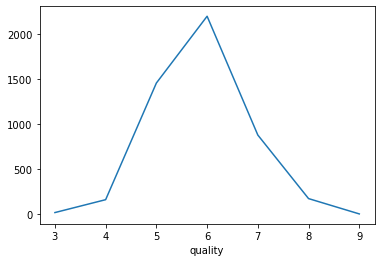

In [17]:
# 품질 데이터별로 그룹을 나누고 수 세어보기
import numpy as np
count_data = wine.groupby('quality')["quality"].count()
print(count_data)

# 수를 그래프로 그리기
count_data.plot()

In [18]:
#RandomForestClassifier  : 결정트리는 정답률이 낮은편에 속한다. 
#여러개의 결정트리를 생성하여 다수결로 최적의 결과를 도출하는 알고리즘이 앙상블 알고리즘이다. 
#RandomForestClassifier 알고리즘은 앙상블 알고리즘중에 하나이다. 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# 데이터를 레이블과 데이터로 분리하기 ---(*1)
y = wine["quality"]
x = wine.drop("quality", axis=1)

# 학습 전용과 테스트 전용으로 분리하기 ---(*2)
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2)

# 학습하기 ---(*3)
model = RandomForestClassifier()
model.fit(x_train, y_train)

# 평가하기 ---(*4)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("정답률=", accuracy_score(y_test, y_pred))
#f1-score:정답률과 재현률의 조화평균, support:정답레이블의 데이터수
#precision : 정답과 예측레이블 데이터중에서 정답인것의 비율 
#recall:재현율 (실제 정답인 것중에서 정답인 것과 예측인 것의 비율을 나타낸다. )


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.86      0.18      0.30        33
           5       0.69      0.70      0.69       293
           6       0.66      0.78      0.71       441
           7       0.68      0.54      0.60       171
           8       0.95      0.50      0.65        36
           9       0.00      0.00      0.00         1

    accuracy                           0.68       980
   macro avg       0.55      0.39      0.42       980
weighted avg       0.68      0.68      0.67       980

정답률= 0.6775510204081633


C:\Users\student\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 정답률을 올려보자~  정답률을 높이기 위해 데이터의 성질을 잘 파악해야한다.

In [25]:
#대부분의 데이터는 5~7사이에 있다. 분포가 불균형인 경우는 분류를 다시하는 것이 좋다.
#즉, 4이하 , 5~7 , 8이상

count_data = wine.groupby('quality')["quality"].count()
print(count_data)

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


In [87]:
#현재
y = wine["quality"]
x = wine.drop("quality", axis=1)
x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [29]:
y = y.apply(lambda val : 0 if val<=4 else (1 if val <=7 else 2 ))

In [247]:
#레이블 변경
# newlist=[]
# for val in list(y):
#     if val <= 4:
#         newlist += [0]
#     elif val <=7:
#         newlist += [1]
#     else:
#         newlist += [2]
# y = newlist
# set(y)
#[1,2,3] + [4] ==> [1,2,3,4]

In [30]:
type(x_train), type(x_test), type(y_train), type(y_test), type(x), type(y)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [31]:
#위의 y변경하고 다시 분리, 학습, 평가 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 학습 전용과 테스트 전용으로 분리하기 ---(*2)
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2)

# 학습하기 ---(*3)
model = RandomForestClassifier()
model.fit(x_train, y_train)

# 평가하기 ---(*4)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("정답률=", accuracy_score(y_test, y_pred))  
#정답률이 큰 폭으로 상승하였다. ....

              precision    recall  f1-score   support

           0       0.78      0.17      0.28        41
           1       0.94      1.00      0.97       907
           2       0.93      0.41      0.57        32

    accuracy                           0.94       980
   macro avg       0.88      0.52      0.61       980
weighted avg       0.94      0.94      0.93       980

정답률= 0.9428571428571428


# 최적의 알고리즘과 매개변수 찾기

In [26]:
!pip install pytest
!pip install Cython

In [16]:
from sklearn.utils.testing import all_estimators
allAlgorithms = all_estimators(type_filter="classifier")
allAlgorithms

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('CheckingClassifier', sklearn.utils._mocking.CheckingClassifier),
 ('ClassifierChain', sklearn.multioutput.ClassifierChain),
 ('ComplementNB', sklearn.naive_bayes.ComplementNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('GaussianProcessClassifier',
  sklearn.gaussian_process._gpc.GaussianProcessClassifier),
 ('GradientBoostingClassifier',
  sklearn.ensemble._gb.GradientBoostingClassifier)

In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.testing import all_estimators
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# 붓꽃 데이터 읽어 들이기
iris_data = pd.read_csv("iris.csv")
# 붓꽃 데이터를 레이블과 입력 데이터로 분리하기 
y = iris_data['variety']
x = iris_data.loc[:, iris_data.columns[:4] ]

# 학습 전용과 테스트 전용 분리하기 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    train_size = 0.8, 
                                                    shuffle = True)

# classifier 알고리즘 모두 추출하기--- (*1)
allAlgorithms = all_estimators(type_filter="classifier")

for(name, algorithm) in allAlgorithms:
    # 각 알고리즘 객체 생성하기 --- (*2)
    print("**************", name)
    if(name == 'CheckingClassifier' or name == 'ClassifierChain' or 
       name == 'MultiOutputClassifier' or name=='OneVsOneClassifier' or 
       name =='OneVsRestClassifier' or name =='OutputCodeClassifier' or
       name =='VotingClassifier' or name=="StackingClassifier"): continue
          
    model = algorithm()
    
    # 학습하고 평가하기 --- (*3)    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(name,"의 정답률 = " , accuracy_score(y_test, y_pred))

************** AdaBoostClassifier
AdaBoostClassifier 의 정답률 =  0.9666666666666667
************** BaggingClassifier
BaggingClassifier 의 정답률 =  0.9666666666666667
************** BernoulliNB
BernoulliNB 의 정답률 =  0.3
************** CalibratedClassifierCV
CalibratedClassifierCV 의 정답률 =  0.8
************** CategoricalNB
CategoricalNB 의 정답률 =  0.8666666666666667
************** CheckingClassifier
************** ClassifierChain
************** ComplementNB
ComplementNB 의 정답률 =  0.6
************** DecisionTreeClassifier
DecisionTreeClassifier 의 정답률 =  0.9666666666666667
************** DummyClassifier
DummyClassifier 의 정답률 =  0.2
************** ExtraTreeClassifier
ExtraTreeClassifier 의 정답률 =  0.9333333333333333
************** ExtraTreesClassifier
ExtraTreesClassifier 의 정답률 =  0.9666666666666667
************** GaussianNB
GaussianNB 의 정답률 =  0.9666666666666667
************** GaussianProcessClassifier
GaussianProcessClassifier 의 정답률 =  0.9666666666666667
************** GradientBoostingClassifier
Gradi

In [34]:
iris_data.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

# Cross Validation ....교차검증

In [36]:
##########################추가 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold_cv = KFold(n_splits=5, shuffle=True)   #5분할  

result = []
#########################
for(name, algorithm) in allAlgorithms:
    # 각 알고리즘 객체 생성하기 --- (*2)
    if(name == 'CheckingClassifier' or name == 'ClassifierChain' or 
       name == 'MultiOutputClassifier' or name=='OneVsOneClassifier' or 
       name =='OneVsRestClassifier' or name =='OutputCodeClassifier' or
       name =='VotingClassifier') or name=="StackingClassifier": continue
          
    model = algorithm()
    
    ###########score메서드를 가진 클래스를 대상으로 하기
    if hasattr(model, "score"):
        scores = cross_val_score(model, x, y, cv=kfold_cv)
        result.append({"name":name ,"mean": np.mean(scores)}) #점수5개의 평균을 구한다....
        
# 위의 이부분이 바뀐것임         
#         model.fit(x_train, y_train)
#         y_pred = model.predict(x_test)
#         print(name,"의 정답률 = " , accuracy_score(y_test, y_pred))


IndexError: index 4 is out of bounds for axis 1 with size 4

In [37]:
result

[{'name': 'AdaBoostClassifier', 'mean': 0.9266666666666665},
 {'name': 'BaggingClassifier', 'mean': 0.96},
 {'name': 'BernoulliNB', 'mean': 0.2533333333333333},
 {'name': 'CalibratedClassifierCV', 'mean': 0.9133333333333334}]

In [38]:
import operator
sorted(result, key=operator.itemgetter("mean","name") , reverse=True)[:5]   #mean과 name으로 sort 

[{'name': 'BaggingClassifier', 'mean': 0.96},
 {'name': 'AdaBoostClassifier', 'mean': 0.9266666666666665},
 {'name': 'CalibratedClassifierCV', 'mean': 0.9133333333333334},
 {'name': 'BernoulliNB', 'mean': 0.2533333333333333}]

In [39]:
aa = [{"name":"정진", "score":100}, {"name":"홍진", "score":90},{"name":"양진", "score":90}]
sorted(aa, key=operator.itemgetter("score", "name"))

[{'name': '양진', 'score': 90},
 {'name': '홍진', 'score': 90},
 {'name': '정진', 'score': 100}]

# 최적의 매개변수 찾기

- 알고리즘 객체를 생성하면서 default 매개변수를 이용할 때와 사용자가 파라메타를 지정할 때 결과는 달라질 것이다.
- 사용자가 정의해야 하는 파라메터를 hyper parameter라고 한다. 
- 최적의 hyper parameter를 찾는 방법
>그리드서치(grid search)  

In [ ]:
#어제 보았던 SVM(Supprt Vector Machine)의 옵션들을 살펴보고 갑시다.)

In [65]:
import matplotlib as mpl
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(
        np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b',
                marker='o', label='클래스 1', s=50)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r',
                marker='s', label='클래스 0', s=50)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


In [66]:
X_xor = np.random.rand(200,2)
X_xor

array([[0.31229862, 0.21404058],
       [0.17231153, 0.80879638],
       [0.62063291, 0.64130078],
       [0.92543726, 0.89179904],
       [0.68046123, 0.96102694],
       [0.22896101, 0.01960223],
       [0.92170678, 0.26432798],
       [0.97310297, 0.22403906],
       [0.2784596 , 0.90944982],
       [0.81265516, 0.09739123],
       [0.57547125, 0.15775161],
       [0.07167158, 0.61238183],
       [0.07805252, 0.47189499],
       [0.61451276, 0.93910267],
       [0.9212722 , 0.60745745],
       [0.50271252, 0.65039118],
       [0.92496549, 0.99094042],
       [0.03309033, 0.96955209],
       [0.80318598, 0.07500484],
       [0.80016788, 0.66263291],
       [0.90573794, 0.45779728],
       [0.50333846, 0.83731331],
       [0.48378779, 0.5263679 ],
       [0.24435888, 0.33042251],
       [0.28764838, 0.04566322],
       [0.58303379, 0.8426515 ],
       [0.77031265, 0.24658564],
       [0.58630969, 0.49043066],
       [0.81655392, 0.35347992],
       [0.03659695, 0.88727581],
       [0.

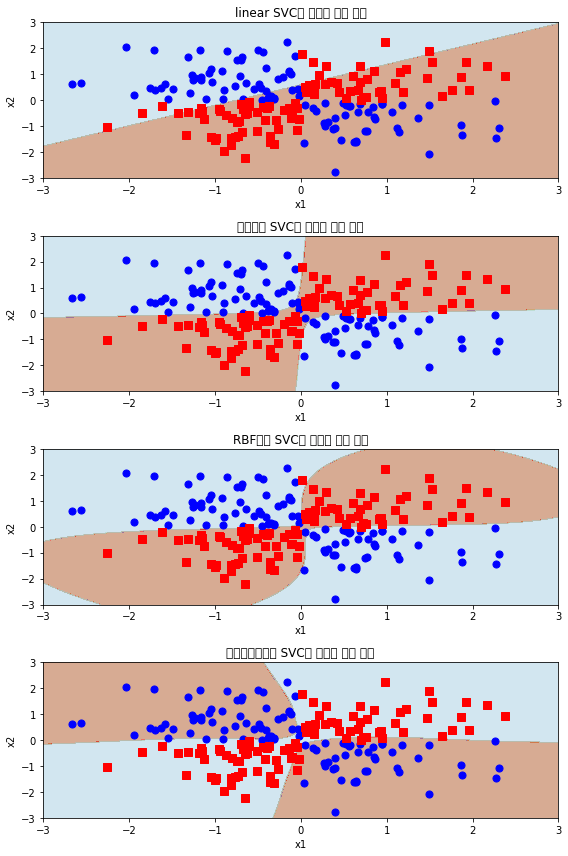

In [70]:
####XOR ....SVM을 사용하면 XOR문제를 풀 수 없다.
from sklearn.svm import SVC

np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

linearsvc = SVC(kernel="linear").fit(X_xor, y_xor)
polysvc = SVC(kernel="poly", degree=2, gamma=1).fit(X_xor, y_xor)
rbfsvc = SVC(kernel="rbf").fit(X_xor, y_xor)
sigmoidsvc = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_xor, y_xor)

plt.figure(figsize=(8, 12))

plt.subplot(411)
plot_xor(X_xor, y_xor, linearsvc, "linear SVC를 사용한 분류 결과")
plt.subplot(412)
plot_xor(X_xor, y_xor, polysvc, "다항커널 SVC를 사용한 분류 결과")
plt.subplot(413)
plot_xor(X_xor, y_xor, rbfsvc, "RBF커널 SVC를 사용한 분류 결과")
plt.subplot(414)
plot_xor(X_xor, y_xor, sigmoidsvc, "시그모이드커널 SVC를 사용한 분류 결과")


plt.tight_layout()
plt.show()

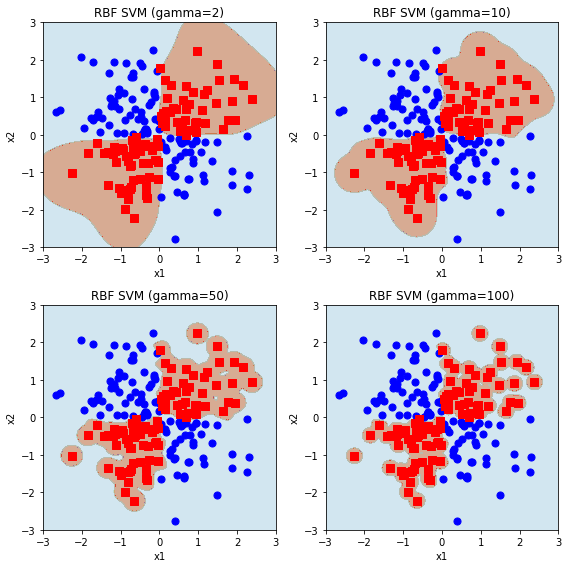

In [71]:
#gamma 옵션 살펴보기 
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=2).fit(X_xor, y_xor), "RBF SVM (gamma=2)")
plt.subplot(222)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=10).fit(X_xor, y_xor), "RBF SVM (gamma=10)")
plt.subplot(223)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVM (gamma=50)")
plt.subplot(224)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=100).fit(X_xor, y_xor), "RBF SVM (gamma=100)")
plt.tight_layout()
plt.show()

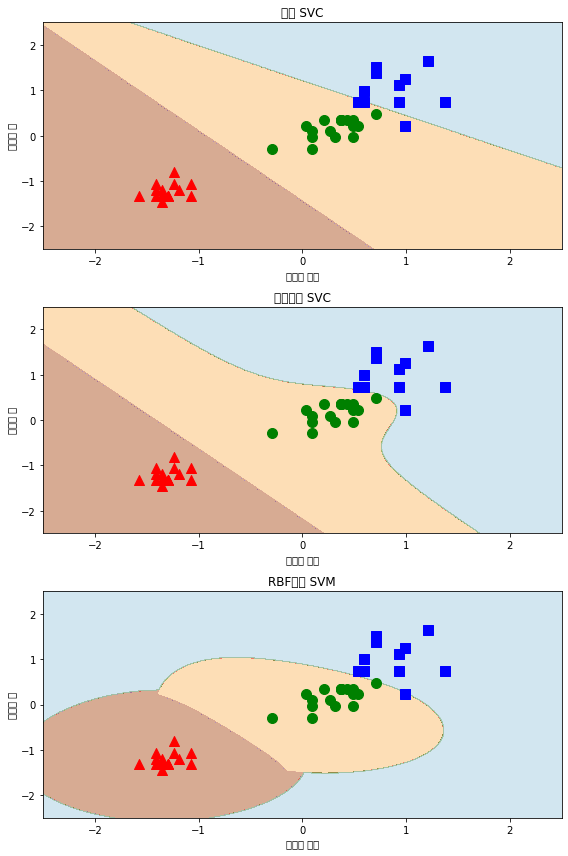

In [72]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#데이터 스케일링을 해주는 이유는 데이터의 값이 너무 크거나 혹은 작은 경우에 
#모델 알고리즘 학습과정에서 0으로 수렴하거나 무한으로 발산해버릴 수 있기 때문입니다.
#StandardScaler : 각 feature의 평균을 0, 분산을 1로 변경합니다. 모든 특성들이 같은 스케일을 갖게된다. 
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y == 2, 0], X[y == 2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("꽃잎의 길이")
    plt.ylabel("꽃잎의 폭")
    plt.title(title)


model1 = SVC(kernel='linear').fit(X_test_std, y_test)
model2 = SVC(kernel='poly', random_state=0,
             gamma=10, C=1.0).fit(X_test_std, y_test)
model3 = SVC(kernel='rbf', random_state=0, gamma=1,
             C=1.0).fit(X_test_std, y_test)

plt.figure(figsize=(8, 12))
plt.subplot(311)
plot_iris(X_test_std, y_test, model1, "선형 SVC")
plt.subplot(312)
plot_iris(X_test_std, y_test, model2, "다항커널 SVC")
plt.subplot(313)
plot_iris(X_test_std, y_test, model3, "RBF커널 SVM")
plt.tight_layout()
plt.show()

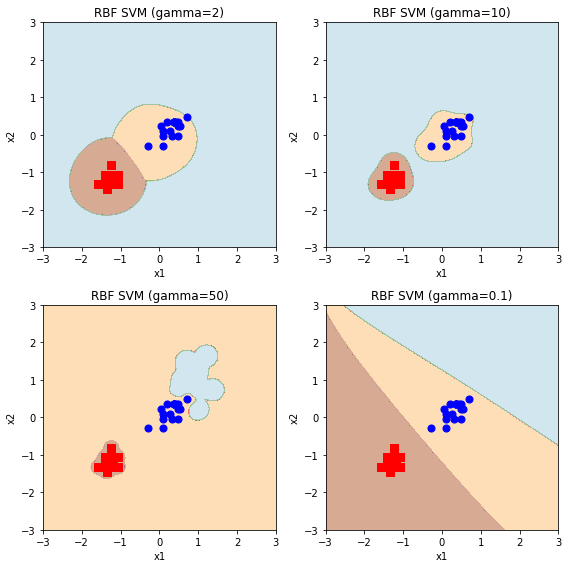

In [73]:
#gamma 옵션 살펴보기 : 굴곡 
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_xor(X_test_std, y_test, SVC(kernel="rbf", gamma=2).fit(X_test_std, y_test), "RBF SVM (gamma=2)")
plt.subplot(222)
plot_xor(X_test_std, y_test, SVC(kernel="rbf", gamma=10).fit(X_test_std, y_test), "RBF SVM (gamma=10)")
plt.subplot(223)
plot_xor(X_test_std, y_test, SVC(kernel="rbf", gamma=50).fit(X_test_std, y_test), "RBF SVM (gamma=50)")
plt.subplot(224)
plot_xor(X_test_std, y_test, SVC(kernel="rbf", gamma=0.1).fit(X_test_std, y_test), "RBF SVM (gamma=0.1)")
plt.tight_layout()
plt.show()

In [85]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# 붓꽃 데이터 읽어 들이기
# 붓꽃 데이터를 레이블과 입력 데이터로 분리하기
y = iris_data.loc[:,"variety"]
x = iris_data.loc[:,iris_data.columns[0:4]]

# 학습 전용과 테스트 전용 분리하기 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, train_size = 0.8, shuffle = True)

In [86]:
# 그리드 서치에서 사용할 매개 변수 --- (이 부분은 SVC알고리즘과 관련된 매개변수들이다.)
#C (cost)
#
#gamma : 구
parameters = [
    {"C": [1, 10, 100, 1000], "kernel":["linear"]},
    {"C": [1, 10, 100, 1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]},
    {"C": [1, 10, 100, 1000], "kernel":["sigmoid"], "gamma": [0.001, 0.0001]}
]

# 그리드 서치 --- (SVC:알고리즘객체, cv는 KFold전용객체이다.)
kfold_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV( SVC(), parameters, cv=kfold_cv)
clf.fit(x_train, y_train)
print("최적의 매개 변수 = ", clf.best_estimator_)

# 최적의 매개 변수로 평가하기 --- (최적의 내개변수로 예측하고 평가한다.)
y_pred = clf.predict(x_test)
print("최종 정답률 = " , accuracy_score(y_test, y_pred))

최적의 매개 변수 =  SVC(C=1, kernel='linear')
최종 정답률 =  0.9666666666666667


In [1]:
## hard voting  & soft voting 

In [79]:
#Moon data
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
# voting이 soft일때는 SVC모델은 probability=True
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [81]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.965034965034965
RandomForestClassifier 0.965034965034965
SVC 0.951048951048951
VotingClassifier 0.972027972027972


In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("정답률=", accuracy_score(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        54
           1       0.97      0.98      0.97        89

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143

정답률= 0.965034965034965
